# Part 1: Training a Convolutional Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-12-09 19:12:11.988083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [3]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))


In [4]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

output_train = output_train.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))
output_test = output_test.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))

In [5]:
X_train_df = pd.DataFrame({"delta_T": input_train.delta_T.data},index=input_train.delta_T.coords['time'].data)

In [6]:
y_train = output_train.velsurf_mag.fillna(-1).data

In [7]:
X_train = X_train_df.to_numpy()

In [8]:
print(X_train.shape,y_train.shape)

(300, 1) (300, 380, 380)


In [9]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [10]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 5
learning_rate  = 0.01
minibatch_size = 64
num_epochs     = 50

In [11]:
model = Sequential()

model.add(Dense(n_filters*19*19, input_shape=(X_train.shape[1],), activation=activation)) # shape:
model.add(Reshape((19,19,n_filters))) # shape: 

# Upsample
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) 
# Upsample
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) 
# Upsample
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=5, padding='same')) 

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11552)             23104     
                                                                 
 reshape (Reshape)           (None, 19, 19, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 38, 38, 32)       25632     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 76, 76, 32)       25632     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 380, 380, 32)     25632     
 ranspose)                                                       
                                                        

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
4/4 [==============================] - 20s 3s/step - loss: 194.7105 - val_loss: 138.9587
Epoch 2/50
4/4 [==============================] - 1s 174ms/step - loss: 176.8042 - val_loss: 124.5704
Epoch 3/50
4/4 [==============================] - 1s 172ms/step - loss: 158.8848 - val_loss: 123.3093
Epoch 4/50
4/4 [==============================] - 1s 173ms/step - loss: 146.6648 - val_loss: 138.7334
Epoch 5/50
4/4 [==============================] - 1s 173ms/step - loss: 139.0258 - val_loss: 136.4085
Epoch 6/50
4/4 [==============================] - 1s 173ms/step - loss: 134.4992 - val_loss: 134.3129
Epoch 7/50
4/4 [==============================] - 1s 173ms/step - loss: 132.2342 - val_loss: 118.8921
Epoch 8/50
4/4 [==============================] - 1s 173ms/step - loss: 130.7948 - val_loss: 113.3295
Epoch 9/50
4/4 [==============================] - 1s 173ms/step - loss: 129.5322 - val_loss: 151.5379
Epoch 10/50
4/4 [==============================] - 1s 173ms/step - loss: 126.9619 - 

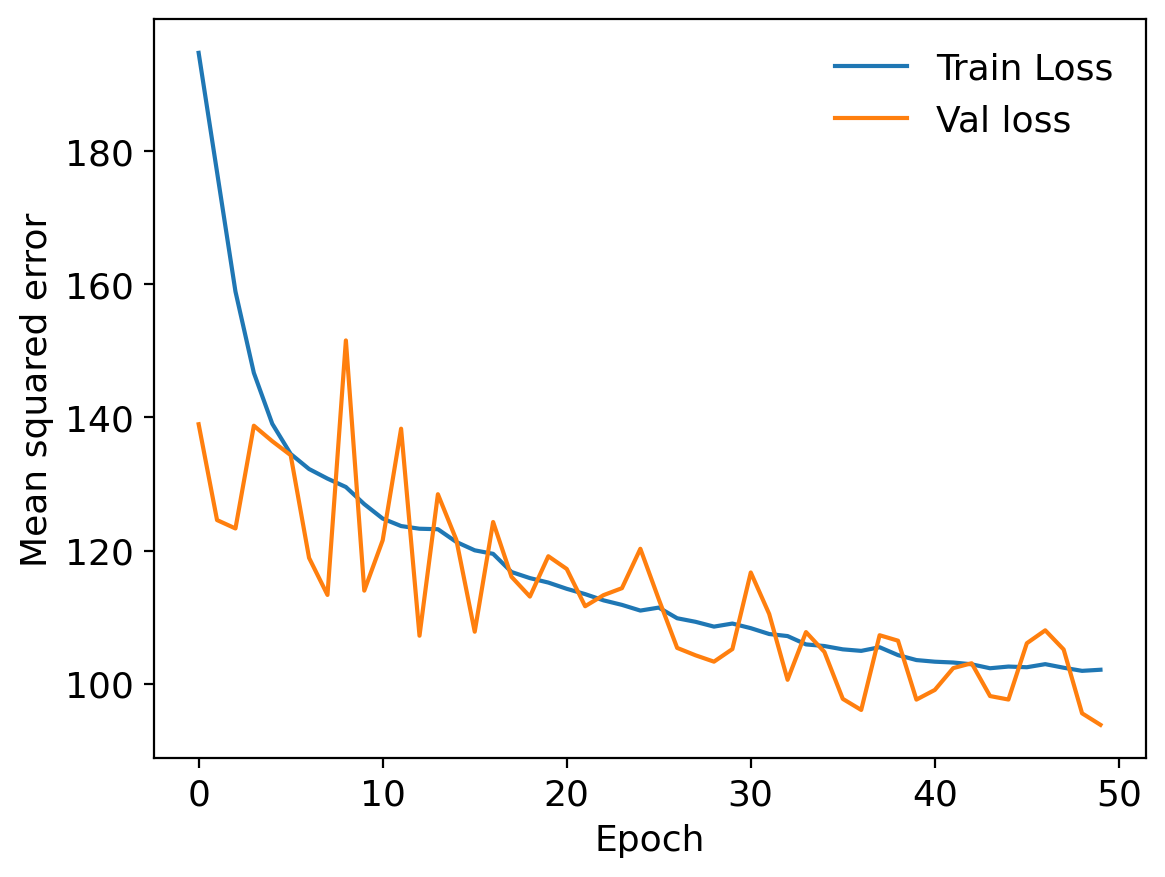

In [14]:
plot_history(history)

In [15]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [59]:
model.save(os.path.join(model_path,'CNN_model_1_member.h5'))

## Testing

In [60]:
model = load_model(os.path.join(model_path,'CNN_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [15]:
X_test_df = pd.DataFrame({"delta_T": input_test.delta_T.data},index=input_test.delta_T.coords['time'].data)

In [16]:
y_test_df = output_test.velsurf_mag

In [17]:
X_test = X_test_df.to_numpy()


In [18]:
y_test_pre = model.predict(X_test)


4/4 [==============================] - 2s 117ms/step


In [19]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.shape[0],y_test_df.shape[1],y_test_df.shape[2])

y_test_pre_xr = xr.Dataset(coords={'time': X_test_df.index.values, 
                               'x': y_test_df.x.values, 
                               'y': y_test_df.y.values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [20]:
y_true =  y_test_df

In [21]:
y_true

<xarray.DataArray 'velsurf_mag' (time: 100, y: 380, x: 380)>
[14440000 values with dtype=float32]
Coordinates:
  * time     (time) float64 -8.48e+04 -8.47e+04 -8.46e+04 ... -7.5e+04 -7.49e+04
  * x        (x) float64 -3.024e+06 -3.008e+06 -2.992e+06 ... 3.024e+06 3.04e+06
  * y        (y) float64 -3.024e+06 -3.008e+06 -2.992e+06 ... 3.024e+06 3.04e+06
Attributes:
    long_name:    magnitude of horizontal velocity of ice at ice surface
    units:        m year-1
    pism_intent:  diagnostic

In [22]:
y_test_pre_xr = y_test_pre_xr+y_true-y_true

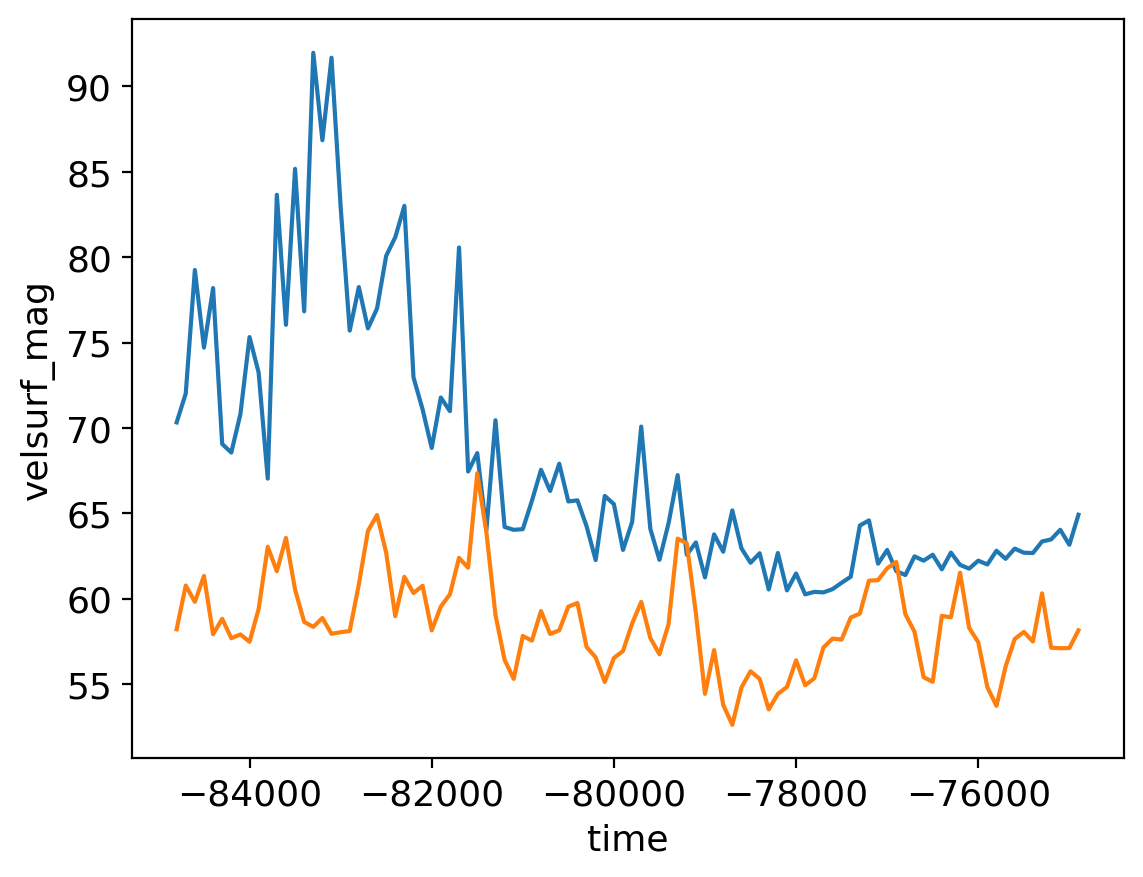

In [23]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()

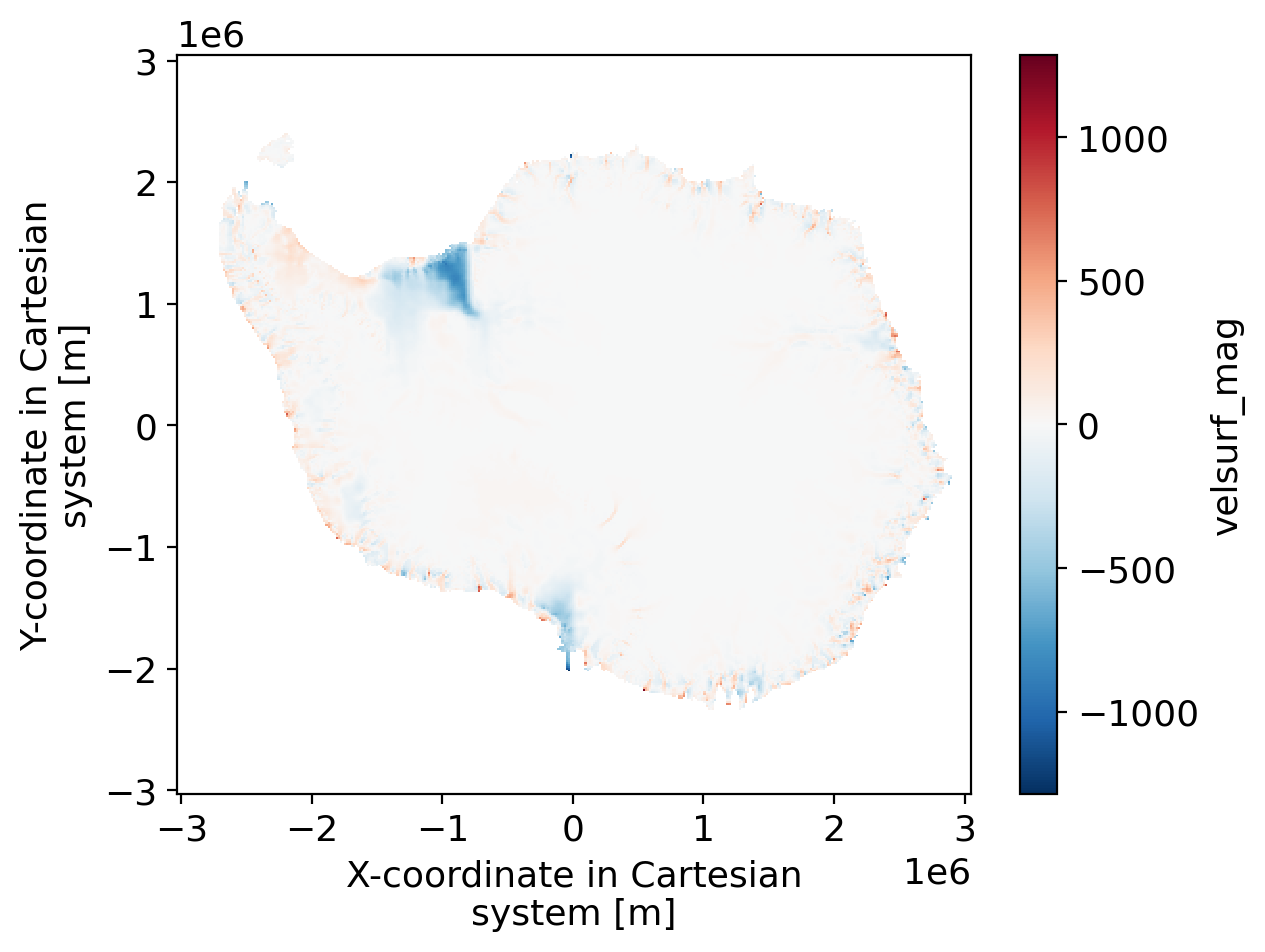

In [24]:
(y_true-y_test_pre_xr.velsurf_mag).mean(dim='time').plot()

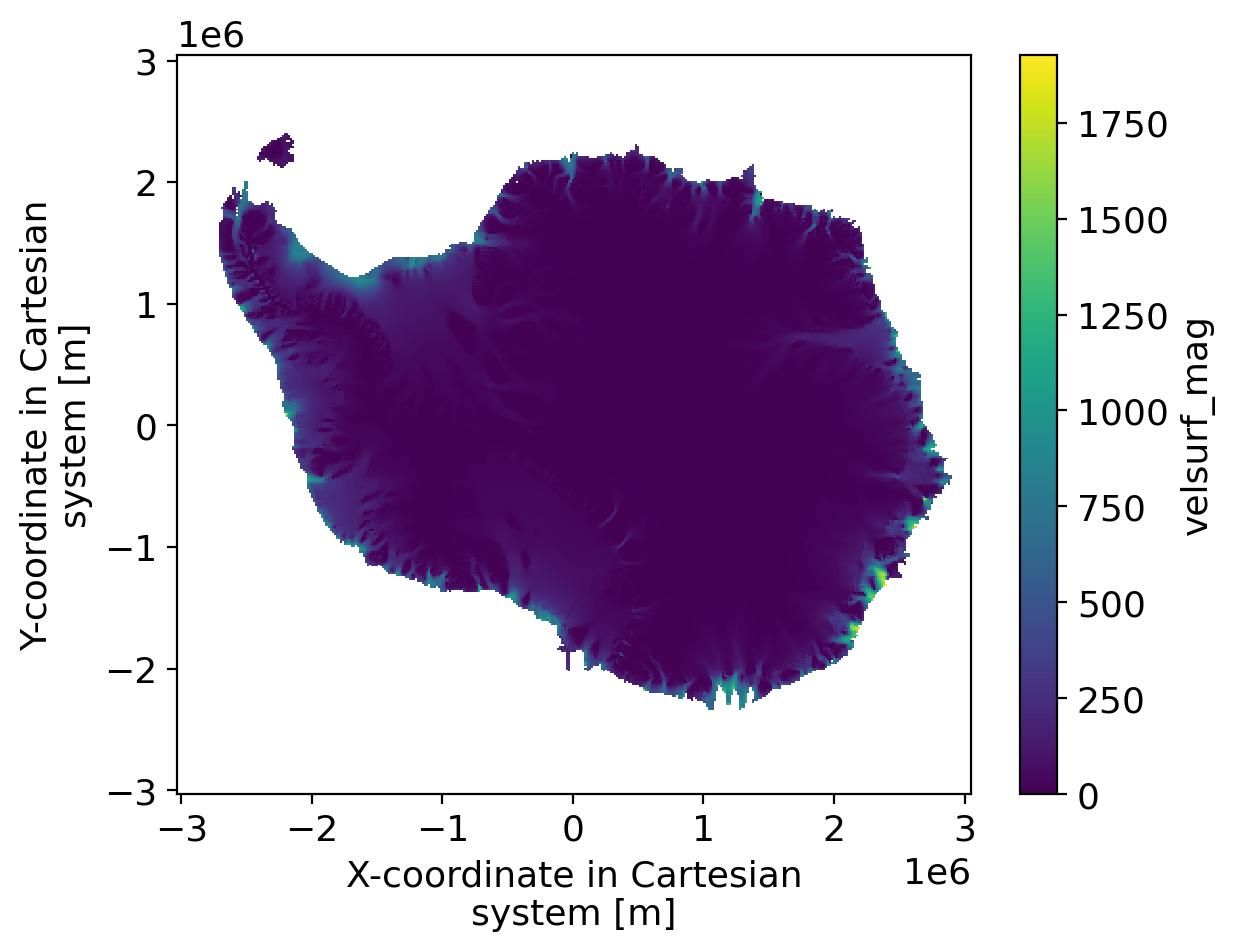

In [25]:
y_true.mean(dim='time').plot()

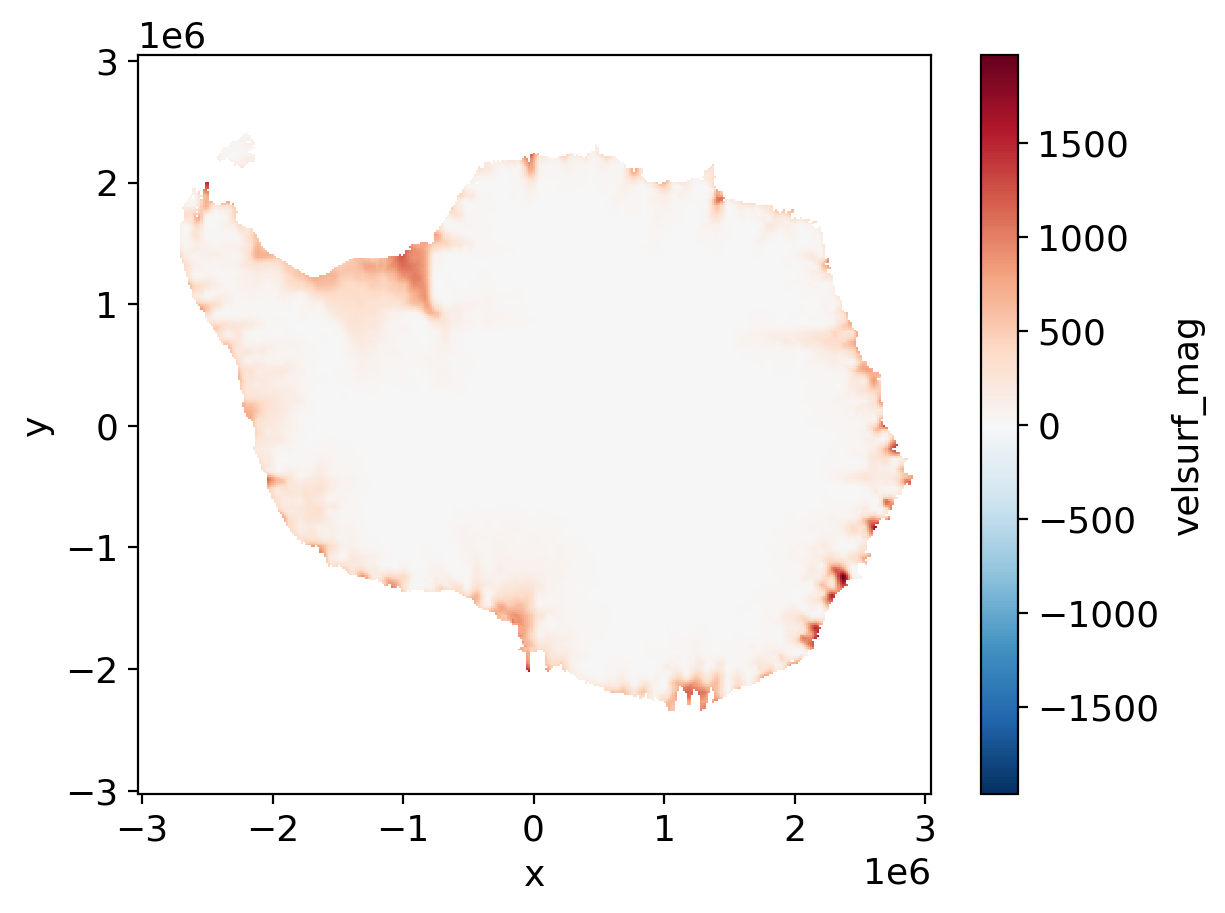

In [26]:
y_test_pre_xr.velsurf_mag.mean(dim='time').plot()

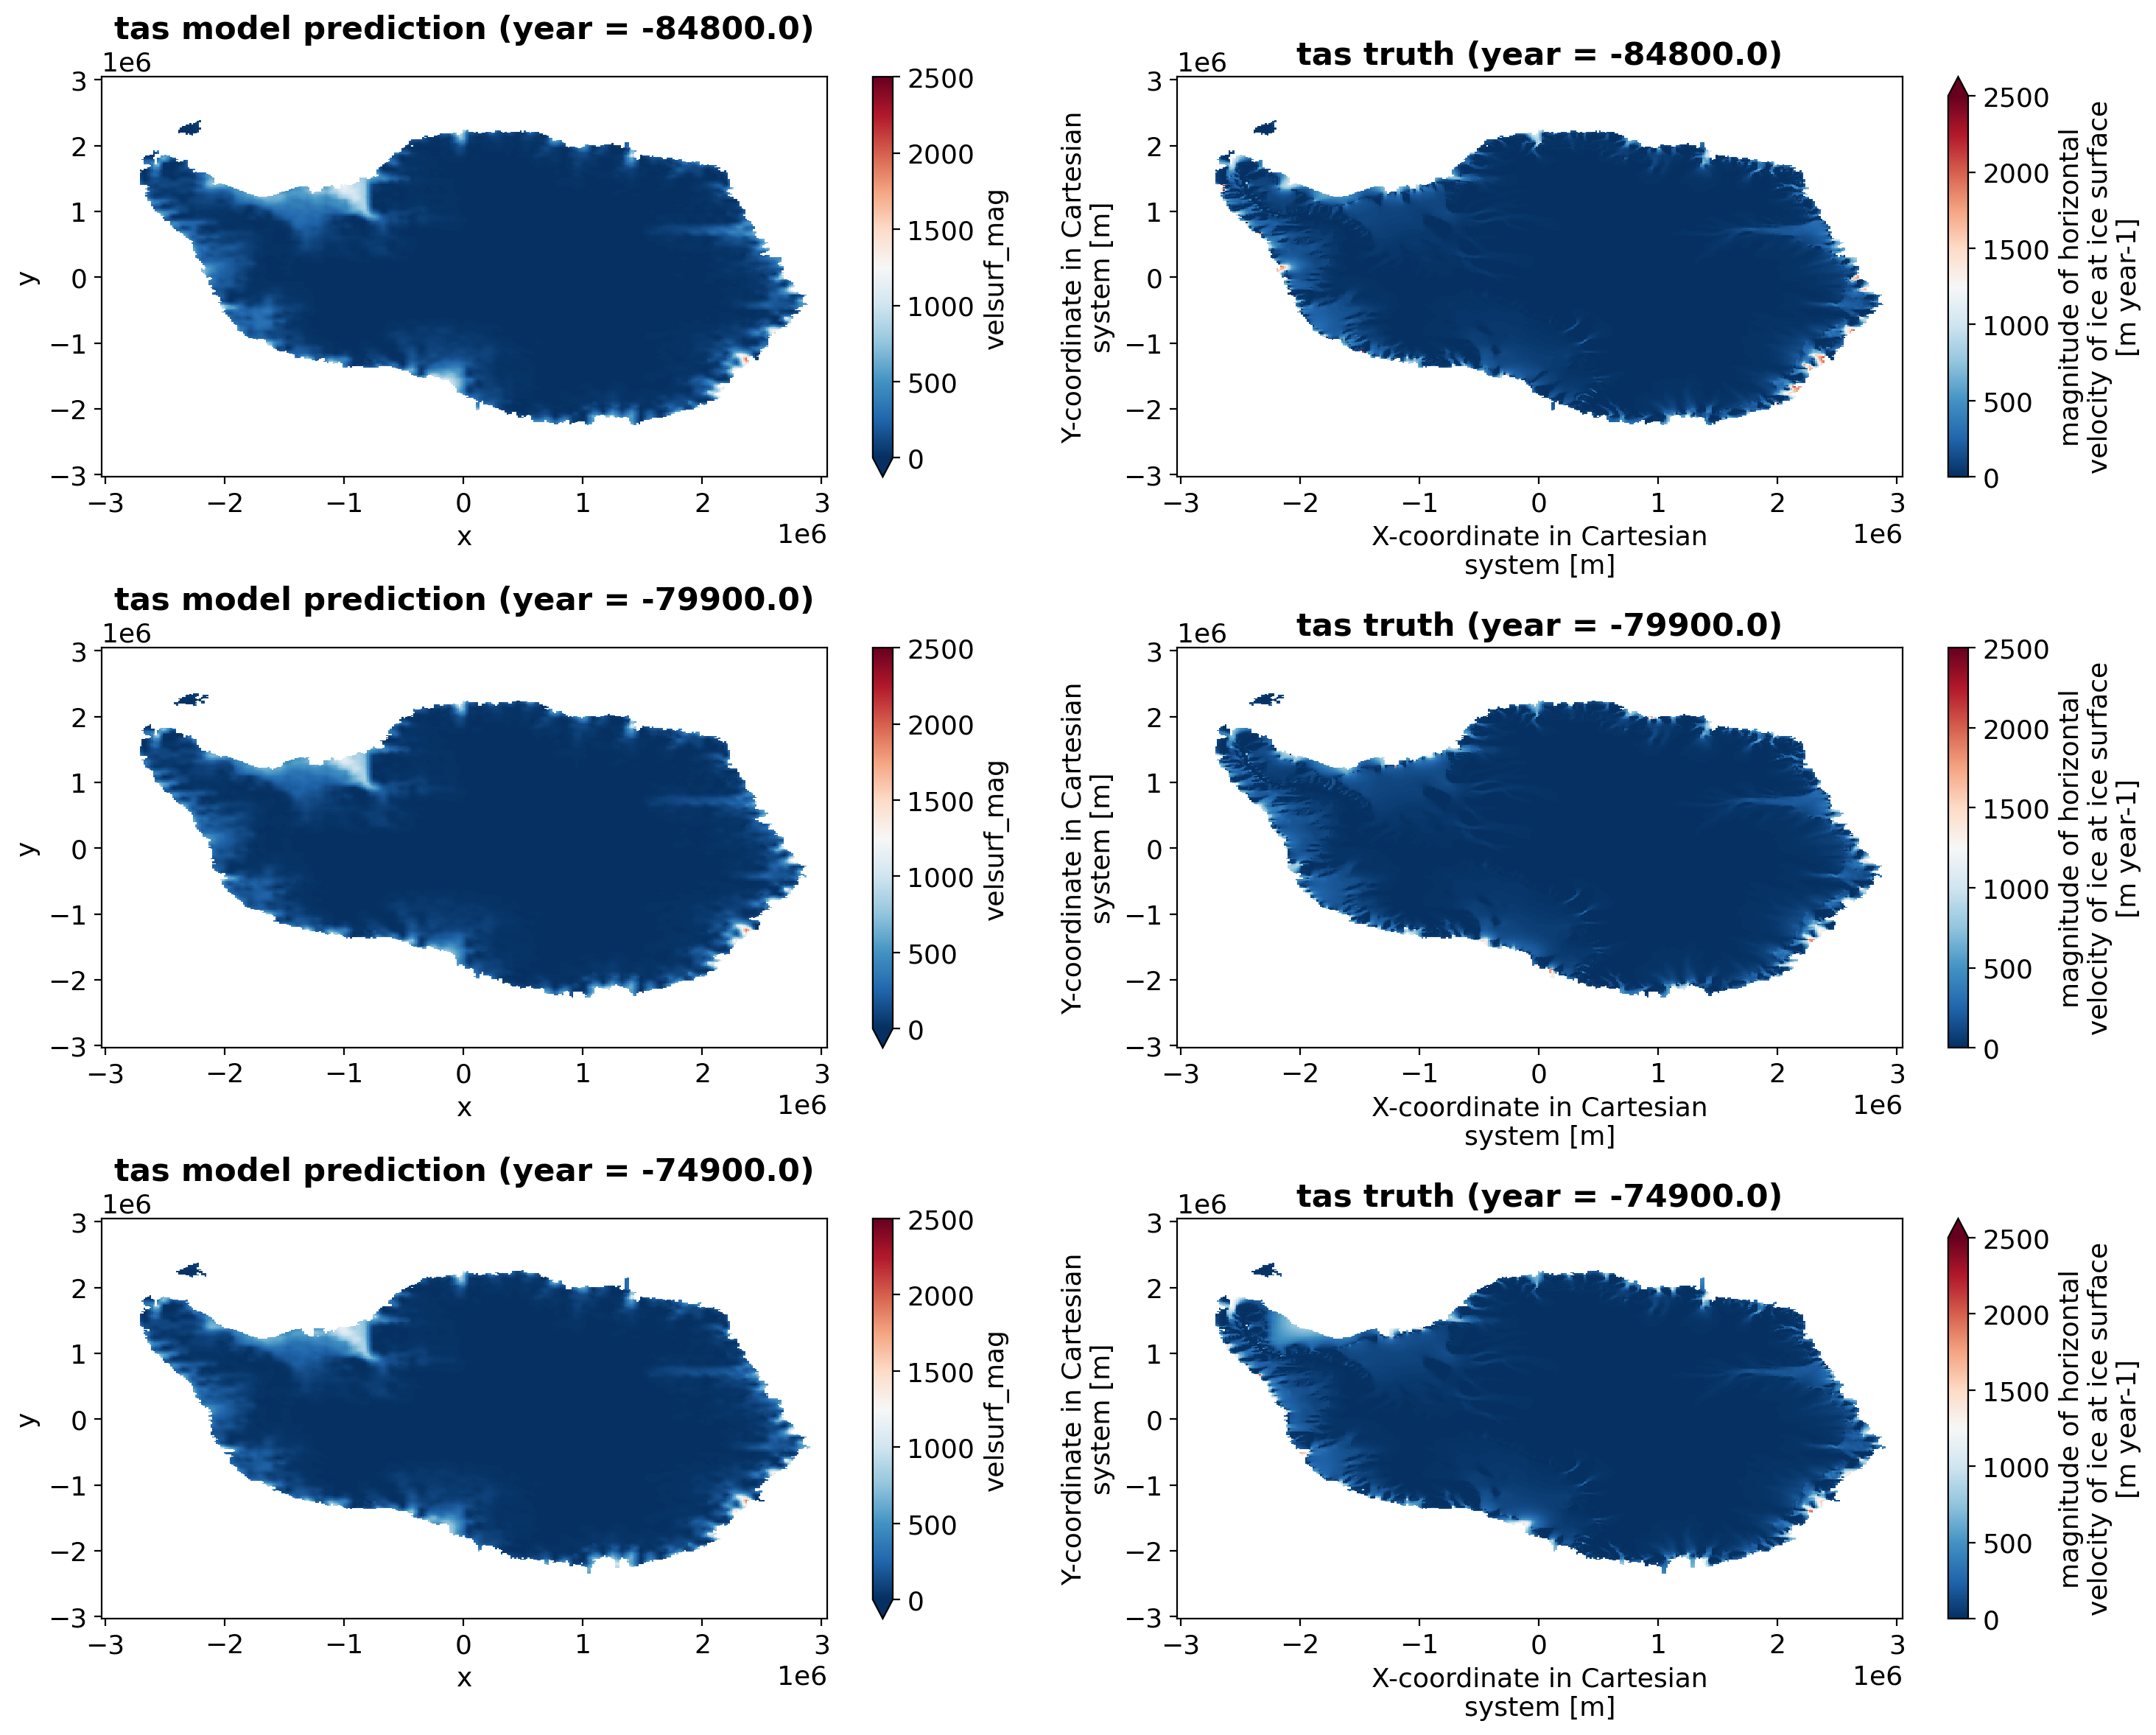

In [27]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [y_test_pre_xr.time[0].values, y_test_pre_xr.time[49].values, y_test_pre_xr.time[-1].values]
vmin, vmax    = 0, 2500
cmap = 'RdBu_r'
y_test_pre_xr.velsurf_mag.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()